# Reverse integrability

A good test of the integrator is first integrate our points backward, and then re-integrate them forward. If the integrator works properly, we should return to the current position only limited by precision from the time step size. This notebook shows the different between the positions of the globular clusters when integrated backwards as point masses and then integrated forward. 

In [1]:
import tstrippy
from astropy import units as u
from astropy import constants as const
from astropy import coordinates as coord
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# give each object a color 
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 15,
})

In [3]:
def plot_relative_stability(tBack,relativeR,relativaV,colors,rlabel,vlabel,title,timestep,
                            ylims=[1e-20,1e-9]):
    nGC=len(relativeR)
    fig,axis=plt.subplots(2,1,figsize=(12,8),sharex=True,gridspec_kw={'hspace':0})
    for i in range(nGC):
        axis[0].plot(tBack,relativeR[i],color=colors[i],alpha=0.5)
        axis[1].plot(tBack,relativaV[i],color=colors[i],alpha=0.5)
    for ax in axis:
        ax.set_yscale('log')
        ax.set_xlim(tBack[0],tBack[-1])
        ax.set_ylim(*ylims)
    axis[0].set_ylabel(rlabel,fontsize=25,rotation=0,labelpad=20)
    axis[1].set_ylabel(vlabel,fontsize=25,rotation=0,labelpad=20)
    axis[1].set_xlabel('Integration time [s kpc/ km]')
    y0ticks=axis[0].get_yticks()
    y1ticks=axis[1].get_yticks()
    axis[0].set_yticks(y0ticks[2:-1]);
    axis[1].set_yticks(y1ticks[1:-2]);
    axis[0].set_title(title)
    axis[0].text(0.95,0.95,'Difference between integrating backward and reintegrating forward',transform=axis[0].transAxes,ha='right',va='top')
    axis[0].text(0.95,0.15,"Integration time step: {:.1e}".format(timestep),transform=axis[0].transAxes,ha='right',va='top')
    return fig,axis

In [4]:
def get_dr_dv_rmean_vmean(backwardOrbit,forwardOrbit):
    """
    Calculate the difference in position and velocity between the backward and forward integration
    """

    dx=backwardOrbit[1]-forwardOrbit[1]
    dy=backwardOrbit[2]-forwardOrbit[2]
    dz=backwardOrbit[3]-forwardOrbit[3]
    dr=np.sqrt(dx**2+dy**2+dz**2)
    dvx=backwardOrbit[4]-forwardOrbit[4]
    dvy=backwardOrbit[5]-forwardOrbit[5]
    dvz=backwardOrbit[6]-forwardOrbit[6]
    dv=np.sqrt(dvx**2+dvy**2+dvz**2)
    xmean=(backwardOrbit[1]+forwardOrbit[1])/2
    ymean=(backwardOrbit[2]+forwardOrbit[2])/2
    zmean=(backwardOrbit[3]+forwardOrbit[3])/2
    vxmean=(backwardOrbit[4]+forwardOrbit[4])/2
    vymean=(backwardOrbit[5]+forwardOrbit[5])/2
    vzmean=(backwardOrbit[6]+forwardOrbit[6])/2
    rmean=np.sqrt(xmean**2+ymean**2+zmean**2)
    vmean=np.sqrt(vxmean**2+vymean**2+vzmean**2)
    return dr,dv,rmean,vmean

def dynamical_time_sorter(x,y,z,vx,vy,vz):
    """
        For making the plots prettier, sort the clusters by dynamical time.
    """
    # get an estimate of all dynamical times of the cluster
    r0=np.sqrt(x**2+y**2+z**2)
    v0=np.sqrt(vx**2+vy**2+vz**2)
    Tdyn=r0/v0
    # sort the clusters by dynamical time
    idx=np.argsort(Tdyn)
    return idx

In [5]:
def loadunits():
    # Load the units
    unitbasis = tstrippy.Parsers.potential_parameters.unitbasis
    unitT=u.Unit(unitbasis['time'])
    unitV=u.Unit(unitbasis['velocity'])
    unitD=u.Unit(unitbasis['distance'])
    unitM=u.Unit(unitbasis['mass'])
    unitG=u.Unit(unitbasis['G'])
    G = const.G.to(unitG).value
    return unitT, unitV, unitD, unitM, unitG, G

In [6]:
def load_globular_clusters_in_galactic_coordinates(MWrefframe):
    """Extract all initial conditions of the globular clusters and transform them the MW frame"""
    unitT, unitV, unitD, unitM, unitG, G = loadunits()
    GCdata  =   tstrippy.Parsers.baumgardtMWGCs().data
    skycoordinates=coord.SkyCoord(
        ra=GCdata['RA'],
        dec=GCdata['DEC'],
        distance=GCdata['Rsun'],
        pm_ra_cosdec=GCdata['mualpha'],
        pm_dec=GCdata['mu_delta'],
        radial_velocity=GCdata['RV'],)
    galacticcoordinates = skycoordinates.transform_to(MWrefframe)
    x,y,z=galacticcoordinates.cartesian.xyz.to(unitD).value
    vx,vy,vz=galacticcoordinates.velocity.d_xyz.to(unitV).value
    return x,y,z,vx,vy,vz

In [7]:
def vanilla_clusters(integrationtime,timestep,staticgalaxy,initialkinematics):
    """
    do the backward and forward integration of the vanilla clusters
    """
    assert isinstance(integrationtime,u.Quantity)
    assert isinstance(timestep,u.Quantity)
    unitT, unitV, unitD, unitM, unitG, G = loadunits()
    Ntimestep=int(integrationtime.value/timestep.value)
    dt=timestep.to(unitT)
    currenttime=0*unitT
    integrationparameters=[currenttime.value,dt.value,Ntimestep]
    nObj = initialkinematics[0].shape[0]

    tstrippy.integrator.setstaticgalaxy(*staticgalaxy)
    tstrippy.integrator.setinitialkinematics(*initialkinematics)
    tstrippy.integrator.setintegrationparameters(*integrationparameters)
    tstrippy.integrator.setbackwardorbit()
    xBackward,yBackward,zBackward,vxBackward,vyBackward,vzBackward=\
        tstrippy.integrator.leapfrogintime(Ntimestep,nObj)
    tBackward=tstrippy.integrator.timestamps.copy()
    tstrippy.integrator.deallocate()

    #### Now compute the orbit forward
    #### IT'S VERY IMPORTANT TO USE tBackward[-1] AS THE CURRENT TIME FOR THE FORWARD INTEGRATION
    #### BEFORE I USED -integrationtime, WHICH CAN BE DIFFERENT BY NSTEP * 1e-16
    #### I.e. A DRIFT IN TIME DUE TO NUMERICAL ERROR, WHICH CAN BECOME SIGNIFICANT FOR INTEGRATING WITH THE BAR
    currenttime=tBackward[-1]*unitT

    integrationparameters=[currenttime.value,dt.value,Ntimestep]
    x0,y0,z0=xBackward[:,-1],yBackward[:,-1],zBackward[:,-1]
    vx0,vy0,vz0 = -vxBackward[:,-1],-vyBackward[:,-1],-vzBackward[:,-1]
    initialkinematics=[x0,y0,z0,vx0,vy0,vz0]
    tstrippy.integrator.setstaticgalaxy(*staticgalaxy)
    tstrippy.integrator.setintegrationparameters(*integrationparameters)
    tstrippy.integrator.setinitialkinematics(*initialkinematics)
    xForward,yForward,zForward,vxForward,vyForward,vzForward=\
        tstrippy.integrator.leapfrogintime(Ntimestep,nObj)
    tForward=tstrippy.integrator.timestamps.copy()
    tstrippy.integrator.deallocate()

    # flip the backorbits such that the point in the past, 
    # which should be the common starting point, 
    # is the first point for both the forward and backward orbits
    tBackward=tBackward[::-1]
    xBackward,yBackward,zBackward=xBackward[:,::-1],yBackward[:,::-1],zBackward[:,::-1]
    vxBackward,vyBackward,vzBackward=-vxBackward[:,::-1],-vyBackward[:,::-1],-vzBackward[:,::-1]
    backwardOrbit  = [tBackward,xBackward,yBackward,zBackward,vxBackward,vyBackward,vzBackward]
    forwardOrbit   = [tForward,xForward,yForward,zForward,vxForward,vyForward,vzForward]
    return backwardOrbit,forwardOrbit

In [8]:
MWparams        = tstrippy.Parsers.potential_parameters.pouliasis2017pii()
MWrefframe      = tstrippy.Parsers.potential_parameters.MWreferenceframe()  
x,y,z,vx,vy,vz  = load_globular_clusters_in_galactic_coordinates(MWrefframe)
staticgalaxy    = ["pouliasis2017pii", MWparams]
initialkinematics=[x,y,z,vx,vy,vz]

# get a unique color for each cluster based on the dynamical time
cmap = plt.get_cmap('twilight')
nGC = len(x)
colors = cmap(np.linspace(0, 1, nGC))
integrationtime =   5e9 * u.yr
timesteps = [1e7*u.yr,1e6*u.yr,1e5*u.yr,1e4*u.yr]

integrate with a series of different timesteps to show the stability of the cluster orbits

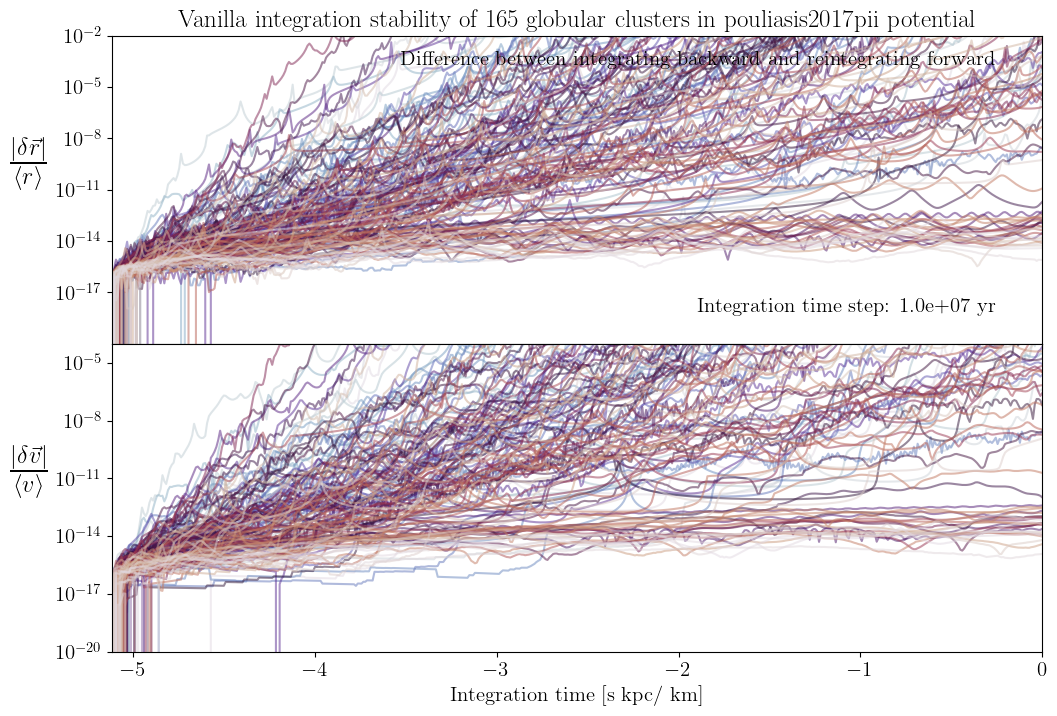

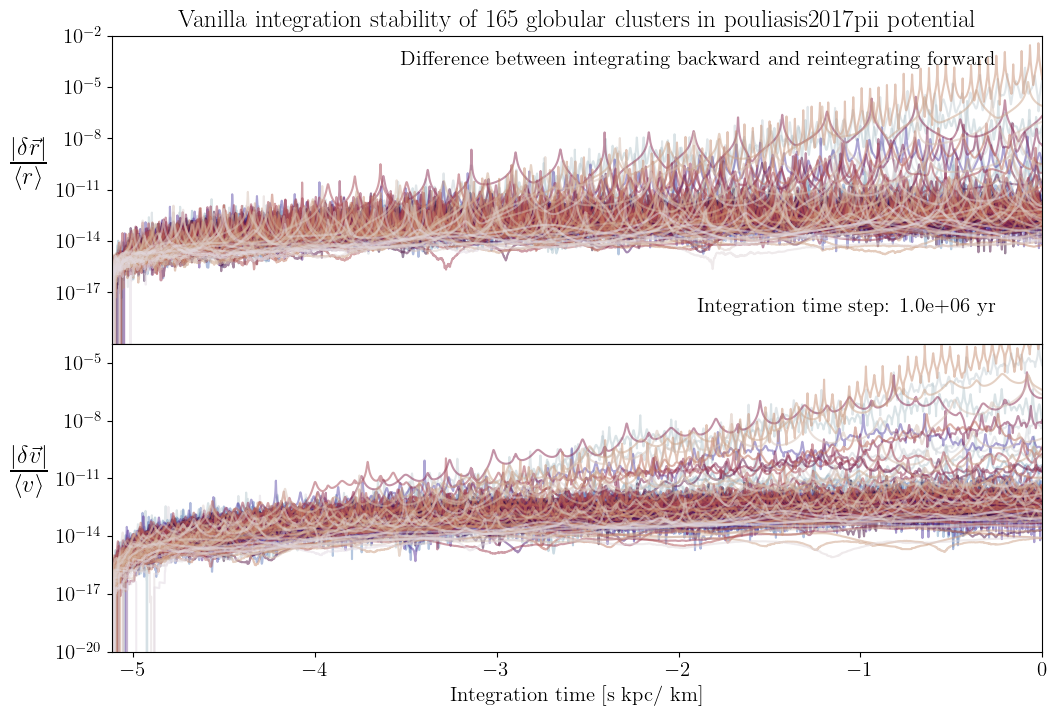

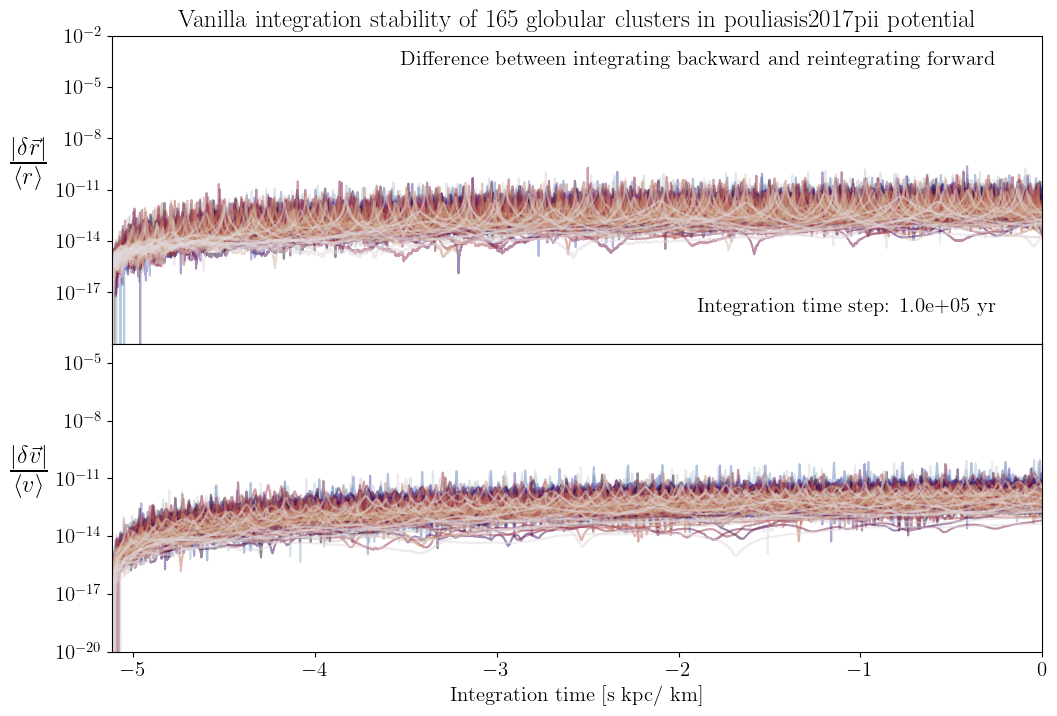

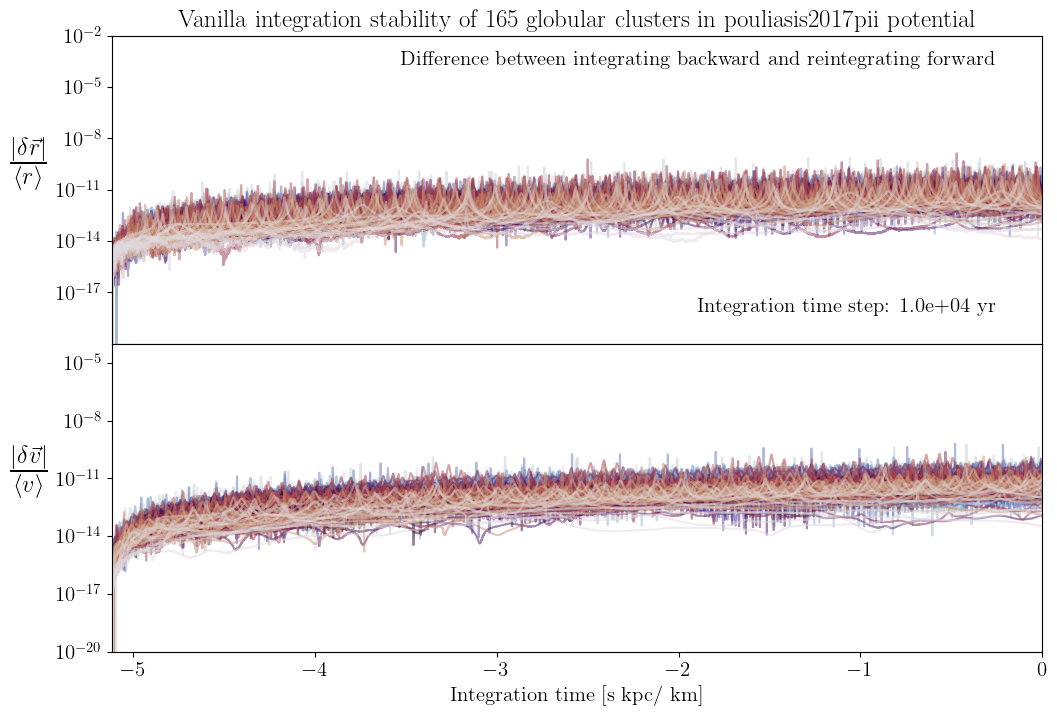

In [9]:
rlabel = r"$\frac{|\delta\vec{r}|}{\langle r \rangle}$"
vlabel = r"$\frac{|\delta\vec{v}|}{\langle v \rangle}$"
ylims = [1e-20,1e-4]
for timestep in timesteps:
    backwardOrbit,forwardOrbit=\
        vanilla_clusters(integrationtime,timestep,staticgalaxy,initialkinematics)
    tBack = backwardOrbit[0]
    dr,dv,rmean,vmean = get_dr_dv_rmean_vmean(backwardOrbit,forwardOrbit)
    idx = dynamical_time_sorter(x,y,z,vx,vy,vz)
    dr,dv,rmean,vmean = dr[idx],dv[idx],rmean[idx],vmean[idx]
    relativeR = dr/rmean
    relativaV = dv/vmean
    title = r"Vanilla integration stability of {:d} globular clusters in {:s} potential".format(nGC,staticgalaxy[0])
    fig,axis=plot_relative_stability(tBack,relativeR,relativaV,colors,rlabel,vlabel,title,timestep,ylims=ylims)